Notes: 
- some helper functions have been modified for this task
- graph specific extra helper functions have been added
- A normalization trick has been used to bound the regression target of all tasks between 0 and 1 and ease meta learning (note that in the original sinewave regression, a bound also existed on the y target based on the wave amplitude).

<h1> Imports and Installs

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Required imports for neural network
import torch.nn as nn
import torch
from torch.autograd import Variable
import random

# For GNNs
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GraphNorm
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
import torch.nn as nn

<h1> Data Loading and Generation

Reptile for regression task using GNNs

Some common GNN datasets are here:
https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.GNNBenchmarkDataset

We will use a regression dataset with 19 regression targets from the paper:
“MoleculeNet: A Benchmark for Molecular Machine Learning”

For this implementation we focus on regressing only the Dipole moment

In [ ]:
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib
# move to python packages directory
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.6/dist-packages/
x86 = '/usr/lib/x86_64-linux-gnu'
!mv lib/*.so.* $x86/
# rdkit need libboost_python3.so.1.65.1
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3753    0  3753    0     0  16829      0 --:--:-- --:--:-- --:--:-- 16829
100 20.2M  100 20.2M    0     0  4752k      0  0:00:04  0:00:04 --:--:-- 5682k


In [ ]:
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 57 kB 3.9 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 


In [ ]:
import torch
from torch_geometric.datasets import TUDataset
#https://chrsmrrs.github.io/datasets/docs/datasets/ alchemy full from the TUDataset
dataset = TUDataset(root='data/TUDataset',name="alchemy_full")

Extracting data/TUDataset/alchemy_full/alchemy_full.zip
Processing...
Done!


In [ ]:
# This function is based on https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

#Function to display properties of the dataset (it is not necessary for anything)
def display_graph_dataset_properties(dataset):
  print()
  print(f'Dataset: {dataset}:')
  print('====================')
  print(f'Number of graphs: {len(dataset)}')
  print(f'Number of features: {dataset.num_features}')
  print(f'Number of classes: {dataset.num_classes}')

  data = dataset[0]  # Get the first graph object.Ç

  print()
  print('Look at a sample graph of the dataset')
  print(data)
  print('=============================================================')

  # Gather some statistics about the first graph.
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

In [ ]:
display_graph_dataset_properties(dataset)


Dataset: alchemy_full(202579):
Number of graphs: 202579
Number of features: 6
Number of classes: 12

Look at a sample graph of the dataset
Data(edge_index=[2, 20], x=[10, 6], edge_attr=[20, 4], y=[1, 12])
Number of nodes: 10
Number of edges: 20
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
# Transform the dataset into a list
dataset_list = []

for i in range(len(dataset)):
  dataset_list.append(dataset[i])

In [ ]:
#Shuffle the dataset list
random.shuffle(dataset_list)
#Split into train and test
GRAPH_TRAIN = dataset_list[:int(np.floor(len(dataset_list)*0.9))]
GRAPH_TEST = dataset_list[int(np.floor(len(dataset_list)*0.9)):]

In [ ]:
GRAPH_TRAIN[3].y

tensor([[ 2.3440e-01,  6.6500e-05,  3.1967e-01, -4.2732e+02, -2.3877e-01,
         -4.2728e+02,  9.6316e+01, -4.2729e+02, -4.2728e+02,  8.0898e-02,
          1.4100e+00,  1.5097e+03]])

<h1> Equivariant Message Passing Model (based on Haitz Sáez de Ocáriz Borde's coursework for L45)

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-geometric==2.0.3

In [ ]:
from torch_geometric.nn import MessagePassing
#To calculate euclidean distance
import torch.nn as nn
pdist = nn.PairwiseDistance(p=2)
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch_scatter import scatter
from torch_scatter import scatter_mean

In [178]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the 
        message passing procedure: `message()` -> `aggregate()` -> `update()`.
        
        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`, 
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j 
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take 
        any arguments that were initially passed to `propagate`. Additionally, 
        we can differentiate destination nodes and source nodes by appending 
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`. 
        
        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features
        
        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`, 
        as well as any optional arguments that were initially passed to 
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

class MPNNModel(Module):
    def __init__(self, num_layers=3, emb_dim=64, in_dim=6, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_max_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

<h1> Simplistic GNN Model

In [179]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GraphNorm

class GCN(torch.nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, output_dim=1):
        super(GCN, self).__init__()

        #Hidden Layers
        self.hidden1 = GCNConv(input_dim, hidden_dim)
        self.hidden2 = GCNConv(hidden_dim, hidden_dim)
        self.hidden3 = GCNConv(hidden_dim, output_dim)
        self.norm = GraphNorm(hidden_dim)

        #Activation Function
        self.relu = nn.ReLU()

        

    def forward(self, data):
        edge_index = data.edge_index
        batch = data.batch
        input_x = data.x
      
        #Standard forward
        x = self.hidden1(input_x,edge_index)
        x = self.norm(x)
        x = self.relu(x)
        x = self.hidden2(x,edge_index)
        x = self.norm(x)
        x = self.relu(x)
        x = self.hidden3(x,edge_index)
        x = self.relu(x)

        #Global mean pool across batches
        x = global_max_pool(x, batch)

        
        return x


In [180]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, output_dim=1):
        super(GAT, self).__init__()

        #Hidden Layers
        self.hidden1 = GATConv(input_dim, hidden_dim)
        self.hidden2 = GATConv(hidden_dim, hidden_dim)
        self.hidden3 = GATConv(hidden_dim, output_dim)
        self.norm = GraphNorm(hidden_dim)

        #Activation Function
        self.relu = nn.ReLU()

        

    def forward(self, data):
        edge_index = data.edge_index
        batch = data.batch
        input_x = data.x
      
        #Standard forward
        x = self.hidden1(input_x,edge_index)
        x = self.norm(x)
        x = self.relu(x)
        x = self.hidden2(x,edge_index)
        x = self.norm(x)
        x = self.relu(x)
        x = self.hidden3(x,edge_index)
        x = self.relu(x)

        #Global mean pool across batches
        x = global_max_pool(x, batch)

        
        return x

In [194]:
choose_model = input('Convolutional:C,Attentional:A,Message Passing:MP')

Convolutional:C,Attentional:A,Message Passing:MPA


<h1> Helper functions

In [213]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    if choose_model == 'C':
      new_model = GCN()
    elif choose_model == 'A':
      new_model = GAT()
    elif choose_model == 'MP':
      new_model = MPNNModel()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,graph,lr_inner,k,store_test_loss_meta,task):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, graph, lr_inner, k,task)
    # Obtain the loss
    loss = evaluation(new_model, graph,task)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,graph,store_train_loss_meta,task):
    loss = evaluation(new_model, graph,task)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, graph, task, item = True, normalization = True):
    # Make model prediction
    prediction = new_model(graph)[:,None]

    label = graph.y[:,task:task+1]
    if normalization == True:
      sigmoid = nn.Sigmoid()
      label = sigmoid(label)

    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, graph, lr_k, k,task):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, graph, task, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

<h1> Additional GNN Helper Functions

Additional helper functions to handle minibatching based on coursework by Haitz Sáez de Ocáriz for L45 Practical 1. The code was partially given in the practical and we had to fill it in, so this is based on my solution. Also, some further modification applied for our implementation: for message passing we include coordinate encoding features and edge attributes, apart from node features, labels, and the adjancency metrics that describes node connectivity.

In [214]:
class Graph(object):
    def __init__(self, edge_index, x, y,edge_attr):
        """ Graph structure 
            for a mini-batch it will store a big (sparse) graph 
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]
        self.edge_attr = edge_attr

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create 
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index, 
                              # we work with a binary adj containing 1 if an edge exist
                              torch.ones((self.edge_index.shape[1])), 
                              torch.Size((self.num_nodes, self.num_nodes))
                              )


In [215]:
def create_mini_batch(graph_list):
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_edge_attr = graph_list[0].edge_attr
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)
    # ============ YOUR CODE HERE =============
    # you may need additional variables
    num_nodes_added= graph_list[0].num_nodes
    # ==========================================

    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):
        # ============ YOUR CODE HERE =============
        # concat the features
        batch_x = torch.cat((batch_x,graph.x))
        # concat the labels
        batch_y = torch.cat((batch_y,graph.y))

        # concat the adjacency matrix as a block diagonal matrix
        batch_edge_index = torch.cat((batch_edge_index, torch.add(graph.edge_index, num_nodes_added)), dim=1)
        batch_edge_attr = torch.cat((batch_edge_attr, graph.edge_attr))
        num_nodes_added += graph.num_nodes
        # ==========================================

        # ============ YOUR CODE HERE =============
        # create the array of indexes mapping nodes in the batch-graph
        # to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)
        batch_batch = torch.cat((batch_batch, torch.full((graph.num_nodes,), idx + 1)))
        # ==========================================
    #create the big sparse graph 
    batch_graph = Graph(batch_edge_index, batch_x, batch_y, batch_edge_attr)
    #attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)
    return batch_graph

<h1> Reptile

In [198]:
#Define important variables
epochs = int(5000) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=10 # how many epochs should we wait to print the loss
lr_k=0.0005 # Internal learning rate
k=18 # Number of internal updates for each task
K = 20 #Number of samples per task
number_of_tasks = 5 #number of tasks for metalearning (max is 19), using 5 converges relatively fast, otherwise it is a bit of a pain
# Initializations
initialization_to_store_meta_losses()

if choose_model == 'C':
  model = GCN()
elif choose_model == 'A':
  model = GAT()
elif choose_model == 'MP':
  model = MPNNModel()

metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [199]:
random.sample(GRAPH_TRAIN, 1)[0].x.shape

torch.Size([9, 6])

In [200]:
random.randint(16, 17)

17

In [201]:
# Training loop
for epoch in range(10000):
        
    # Sample a task at random 0-18 regression tasks --> T, task should only change per epoch, so it is only updated here
    task = random.randint(0,10) #Note that for this problem 'task' must be passed to the evaluation function --> graph.y has all the selection targets, we only use the one specified by task

    # Empty list
    graph = []

    for i in range(K): #Store graphs
      graph.append(random.sample(GRAPH_TRAIN, 1)[0])

    # Create graph mini batch from list
    graph = create_mini_batch(graph)

    # Update model predefined number of times based on k
    new_model = training(model, graph, lr_k, k,task)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,graph,store_train_loss_meta,task)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the graph from the test data

    graph = []
    for i in range(K): #Store graphs
      graph.append(random.sample(GRAPH_TEST, 1)[0])
    graph = create_mini_batch(graph)

    test_set_validation(model,new_model,graph,lr_k,k,store_test_loss_meta,task)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epochh : 0, Average Train Meta Loss : 0.07151384651660919, Average Test Meta Loss : 0.07801181077957153
Epochh : 10, Average Train Meta Loss : 0.054341688582843, Average Test Meta Loss : 0.03674602144482461
Epochh : 20, Average Train Meta Loss : 0.04987047249007793, Average Test Meta Loss : 0.041961826517113616
Epochh : 30, Average Train Meta Loss : 0.05843563137515899, Average Test Meta Loss : 0.05574343452650693
Epochh : 40, Average Train Meta Loss : 0.05715262180580417, Average Test Meta Loss : 0.05947473498697325
Epochh : 50, Average Train Meta Loss : 0.0659459102761877, Average Test Meta Loss : 0.06446847318689905
Epochh : 60, Average Train Meta Loss : 0.06240270313135058, Average Test Meta Loss : 0.06076873220564401
Epochh : 70, Average Train Meta Loss : 0.0602330001280971, Average Test Meta Loss : 0.05754436742724248
Epochh : 80, Average Train Meta Loss : 0.06172102911938212, Average Test Meta Loss : 0.057975035497809496
Epochh : 90, Average Train Meta Loss : 0.05871595138335948

<h1> Few Shot learning with new meta-model

The model performs good few shot learning

In [203]:
model_copy = copy_existing_model(model)

In [204]:
if choose_model == 'C':
  model_random = GCN()
elif choose_model == 'A':
  model_random = GAT()
elif choose_model == 'MP':
  model_random = MPNNModel()

In [216]:
task = 11
graph = []
for i in range(K): #Store graphs
    graph.append(random.sample(GRAPH_TEST, 1)[0])
graph = create_mini_batch(graph)

k_shot_updates = 6
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model_copy, graph, lr_k,shots, task)
    train_set_evaluation(new_model,graph,store_train_loss_meta, task) 

plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')

RuntimeError: ignored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 0, 'k shots')

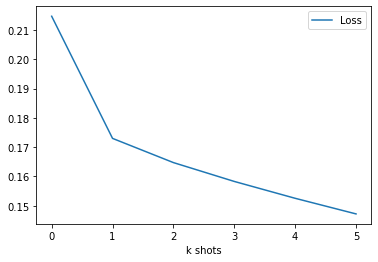

In [206]:
task = 11
graph = []
for i in range(K): #Store graphs
    graph.append(random.sample(GRAPH_TEST, 1)[0])
graph = create_mini_batch(graph)

k_shot_updates = 6
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model_random, graph, lr_k,shots, task)
    train_set_evaluation(new_model,graph,store_train_loss_meta, task) 

plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')